# Problematic Internet Habits in Children

Eric Mossotti (None)

In [ ]:
!kaggle competitions download -c child-mind-institute-problematic-internet-use 

In [ ]:
from zipfile import ZipFile
import os
import duckdb
import pandas as pd
from colorama import Fore, Style
import re

In [ ]:
try:
  os.mkdir('data')
except FileExistsError:
  print(f"data exists")

data exists

In [ ]:
zip_path = "child-mind-institute-problematic-internet-use.zip"

if not os.path.exists('data/train.csv'):
  with ZipFile(zip_path) as zf:
    ZipFile.extractall(zf, path = 'data')
    print(
      f"files were extracted"
      ,pd.DataFrame(data = os.listdir('data'), columns = ['data'])
      ,sep = "\n"*2
      )
else:
  print(
    f"files were already extracted"
    ,pd.DataFrame(data = os.listdir('data'), columns = ['data'])
    ,sep = "\n"*2
    )

files were already extracted

                    data
0               test.csv
1    data_dictionary.csv
2  sample_submission.csv
3    series_test.parquet
4   series_train.parquet
5              train.csv

## Open Connection

In [ ]:
conn = duckdb.connect(':memory:')
conn.sql(f"SET memory_limit = '24GB';")
conn.sql(f"SET default_order = 'ASC';")

## Enumerate

In [ ]:
enums = ['internet_hours_enum'
         ,'enroll_season_enum'
         ,'disease_risk_enum'
         ,'sii_enum', 'age_enum'
         ,'sex_enum'
         ,'pciat_season_enum'
         ,'weekday_enum'
         ,'quarter_enum'
         ,'hour_enum'
         ,'minute_enum'
         ,'second_enum'
         ,'id_actigraphy_enum']

#siiSeries = pd.Series(data = ['None', 'Mild', 'Moderate', 'Severe'], dtype = str)
siiSeries = pd.Series(data = ['0', '1', '2', '3'], dtype = str)
ageSeries = pd.Series(data = range(5, 23), dtype = str)
sexSeries = pd.Series(data = ['0', '1'], dtype = str)
pciatSeasonSeries = pd.Series(data = ['Fall', 'Spring', 'Summer', 'Winter'], dtype = str)
internetHrsSeries = pd.Series(data = ['0', '1', '2', '3'], dtype = str)
quarterSeries = pd.Series(data = range(1, 5), dtype = str)
weekdaySeries = pd.Series(data = range(1, 8), dtype = str)
hourSeries = pd.Series(data = range(0, 24), dtype = str)
minuteSeries = pd.Series(data = range(0, 60), dtype = str)
secondSeries = pd.Series(data = range(0, 60), dtype = str)
diseaseRiskSeries = pd.Series(data = ['Underweight'
                                      ,'Normal'
                                      ,'Increased'
                                      ,'High'
                                      ,'Very High'
                                      ,'Extremely High'], dtype = str)

id_df = conn.execute(f"""
     SELECT 
         DISTINCT(id) AS id
     FROM 
         read_parquet('data/series_train*/*/*'
         ,hive_partitioning = true)
     ORDER BY 
         id ASC;
     """).df() 

idList = id_df['id'].to_list()
idSeries = pd.Series(data = idList, dtype = str)

enumDict = {
  'disease_risk_enum': f"{tuple(diseaseRiskSeries)}"
  ,'enroll_season_enum': f"{tuple(pciatSeasonSeries)}"
  ,'sii_enum': f"{tuple(siiSeries)}"
  ,'age_enum': f"{tuple(ageSeries)}"
  ,'sex_enum': f"{tuple(sexSeries)}"
  ,'pciat_season_enum': f"{tuple(pciatSeasonSeries)}"
  ,'quarter_enum': f"{tuple(quarterSeries)}"
  ,'weekday_enum': f"{tuple(weekdaySeries)}"
  ,'hour_enum': f"{tuple(hourSeries)}"
  ,'minute_enum': f"{tuple(minuteSeries)}"
  ,'second_enum': f"{tuple(secondSeries)}"
  ,'id_actigraphy_enum': f"{tuple(idSeries)}"
  ,'internet_hours_enum': f"{tuple(internetHrsSeries)}"
  }

if len(enumDict) == len(enums):
    print(f"drops and creates are same length")
else:
  print(f"drops and creates are not the same length")

drops and creates are same length

In [ ]:

def try_create(conn, type_str: str, enum_str: str) -> pd.Series:
  try:
    conn.execute(f"CREATE TYPE {type_str} AS ENUM {enum_str};")
    return pd.Series(type_str, index = ['created'])
  except duckdb.duckdb.CatalogException:
    return pd.Series(type_str, index = ['already existo'])

def try_drop(conn, type_str: str) -> pd.Series:
  try:
    conn.execute(f"DROP TYPE {type_str};")
    return pd.Series(type_str, index = ['dropped'])
  except duckdb.duckdb.CatalogException:
    return pd.Series(type_str, index = ['could not drop'])

In [ ]:
droplist = []
for e in enums:   
   droplist.append(try_drop(conn, type_str = e))
   
dropFrame = pd.DataFrame(droplist)
dropFrame = dropFrame.sort_values(by = dropFrame.columns.to_list()
                                  ,ascending=True
                                  ,ignore_index=True)
createList = []
for eType, eSeries in enumDict.items():
    createList.append(try_create(conn
                                 ,type_str = eType
                                 ,enum_str = eSeries))
createFrame = pd.DataFrame(createList)
createFrame = createFrame.sort_values(by = createFrame.columns.to_list()
                                      ,ascending=True
                                      ,ignore_index=True)

pd.concat([dropFrame, createFrame], axis = 1)

         could not drop              created
0              age_enum             age_enum
1     disease_risk_enum    disease_risk_enum
2    enroll_season_enum   enroll_season_enum
3             hour_enum            hour_enum
4    id_actigraphy_enum   id_actigraphy_enum
5   internet_hours_enum  internet_hours_enum
6           minute_enum          minute_enum
7     pciat_season_enum    pciat_season_enum
8          quarter_enum         quarter_enum
9           second_enum          second_enum
10             sex_enum             sex_enum
11             sii_enum             sii_enum
12         weekday_enum         weekday_enum

In [ ]:
trainCsvDf = pd.read_csv("data/train.csv")
testCsvDf = pd.read_csv("data/test.csv")
dictDf = pd.read_csv("data/data_dictionary.csv")

In [ ]:
trainCsvDf.columns = trainCsvDf.columns.str.replace('-','_') 
trainCsvDf.columns = trainCsvDf.columns.str.lower() 
testCsvDf.columns = testCsvDf.columns.str.replace('-','_') 
testCsvDf.columns = testCsvDf.columns.str.lower() 

dictDf.Field = dictDf.Field.replace("-", "_", regex = True)

csvDict = {
  "TrainCsv": trainCsvDf
  ,"TestCsv": testCsvDf
  ,"DataDict": dictDf
  }

parquetDict = {
  "ActigraphyTrain": 'data//series_train.parquet*/*/*'
  ,"ActigraphyTest": 'data//series_test*/*/*'
  }

## Setup Database Pipeline

In [ ]:
def setup_duckdb_pipeline(
  csvDict: dict, 
  parquetDict: dict, 
  conn: duckdb.DuckDBPyConnection) -> None:
  try:
    {
      table_name: duckdb.sql(f"""
      CREATE OR REPLACE TABLE {table_name} AS 
      SELECT 
        *
      FROM 
        df;
      """, connection = conn) 
      for table_name, df in csvDict.items()
      }
    for key, value in csvDict.items():
      result = conn.execute(f"SELECT COUNT(*) FROM {key}").fetchone()
      print(
        Style.BRIGHT + f"Successfully created table:"
        ,Style.NORMAL + Fore.LIGHTYELLOW_EX + f"{key},"
        ,Style.BRIGHT + Fore.RESET + f"Row count:"
        ,Style.NORMAL + Fore.CYAN + f"{result[0]}"
        ,Fore.RESET
        )
  except Exception as e:
    print(f"Error loading table: {str(e)}")
    raise
  
  if parquetDict:
    write_datasets(conn, parquetDict)
  
# Create tables from Parquet files
def write_datasets (
  conn: duckdb.DuckDBPyConnection, parquetDict: dict):
      try:
        {
          table_name: duckdb.sql(f"""
           CREATE OR REPLACE TABLE {table_name} AS
           SELECT 
             id::id_actigraphy_enum AS id
             ,quarter::TEXT::quarter_enum AS quarter
             ,weekday::TEXT::weekday_enum AS weekday
             ,light
             ,time_of_day
             ,relative_date_PCIAT
           FROM read_parquet(
             '{file_path}'
             ,hive_partitioning = true
             );""", connection=conn)
           for table_name, file_path in parquetDict.items()
           }
        #{name: conn.register(
        #  name, dataSet) for name, dataSet in parquetDict.items()}
        for key, value in parquetDict.items():
          result = conn.execute(f"SELECT COUNT(*) FROM {key}").fetchone()
          print(
            Style.BRIGHT + f"Successfully created table:"
            ,Style.NORMAL + Fore.LIGHTBLUE_EX + f"{key},"
            ,Style.BRIGHT + Fore.RESET + f"Row count:"
            ,Style.NORMAL + Fore.LIGHTGREEN_EX + f"{result[0]}"
            ,Fore.RESET
            )
      except Exception as e:
        print(f"Error writing dataset: {str(e)}")
        raise

In [ ]:
setup_duckdb_pipeline(csvDict, parquetDict, conn)

Successfully created table: TrainCsv, Row count: 3960 
Successfully created table: TestCsv, Row count: 20 
Successfully created table: DataDict, Row count: 81 
Successfully created table: ActigraphyTrain, Row count: 314569149 
Successfully created table: ActigraphyTest, Row count: 439726 

In [ ]:
conn.sql(f"CHECKPOINT;")

┌─────────┐
│ Success │
│ boolean │
├─────────┤
│ 0 rows  │
└─────────┘

In [ ]:
coltype_overview = conn.execute(f"""
  SELECT 
    column_name
    ,data_type
  FROM 
    information_schema.columns
  WHERE 
    table_name = 'TrainCsv';""").df()

# map the column names with data types
col_dict = dict(zip(coltype_overview.column_name, coltype_overview.data_type))

In [ ]:
regex_dict_train = {
  "Demographic": r"^id|^sii|^basic\S+"
  ,"Physical": r"^id|^sii|^physical\S+"
  ,"FgVital": r"^id|^sii|^fitness_E\S+"
  ,"FgChild": r"^id|^sii|^fgc\S+"
  ,"Bia": r"^id|^sii|^bia\S+"
  ,"Paqa": r"^id|^sii|^paq_a\S+"
  ,"Pciat": r"^id|^sii|^pciat\S+"
  ,"Sds": r"^id|^sii|^sds\S+"
  ,"InternetUse": r"^id|^sii|^preint\S+"
  }

regex_dict_test = {
  "Demographic_OfTest": r"^id|^basic\S+"
  ,"Physical_OfTest": r"^id|^physical\S+"
  ,"FgVital_OfTest": r"^id|^fitness_E\S+"
  ,"FgChild_OfTest": r"^id|^fgc\S+"
  ,"Bia_OfTest": r"^id|^bia\S+"
  ,"Paqa_OfTest": r"^id|^paq_a\S+"
 # ,"Pciat_OfTest": r"^id|^pciat\S+" 
  ,"Sds_OfTest": r"^id|^sds\S+"
  ,"InternetUse_OfTest": r"^id|^preint\S+"
  }

## Parameterizing Database Tables

In [ ]:

def filter_columns_by_regex(col_dict: dict, regex_pattern: str) -> dict:
  """
  Filter column dictionary based on a regex pattern
  """
  return {
    col: dtype 
    for col, dtype in col_dict.items() 
    if re.search(regex_pattern, col)
    }

def create_table_with_regex_columns(
  conn: duckdb.duckdb
  ,source_table: str
  ,new_table_name: str 
  ,regex_pattern: str 
  ,col_dict: dict
  ) -> None:  
  """
  Create a new table with columns matching a regex pattern
  """
  # filter columns
  filtered_col_dict = filter_columns_by_regex(col_dict, regex_pattern)
  
  # regex column selecting via dict comprehension
  regex_select_sql = f"""
  CREATE OR REPLACE TABLE {new_table_name} AS 
  SELECT
    {', '.join([f'"{col}"' for col in filtered_col_dict.keys()])}
  FROM {source_table};
  """

  conn.execute(regex_select_sql)

In [ ]:
for new_table_name, regex_pattern in regex_dict_train.items():
  create_table_with_regex_columns(
    conn 
    ,'TrainCsv'
    ,new_table_name
    ,regex_pattern
    ,col_dict
    ) 

for new_table_name, regex_pattern in regex_dict_test.items():
  create_table_with_regex_columns(
    conn
    ,'TestCsv'
    ,new_table_name
    ,regex_pattern 
    ,col_dict
    )

In [ ]:
conn.sql(f"select * from ActigraphyTest limit 10;").df()

         id quarter weekday      light     time_of_day  relative_date_PCIAT
0  00115b9f       3       4  53.000000  56940000000000                 41.0
1  00115b9f       3       4  51.666668  56945000000000                 41.0
2  00115b9f       3       4  50.333332  56950000000000                 41.0
3  00115b9f       3       4  50.500000  56955000000000                 41.0
4  00115b9f       3       4  33.166668  57235000000000                 41.0
5  00115b9f       3       4  31.333334  57240000000000                 41.0
6  00115b9f       3       4  29.500000  57245000000000                 41.0
7  00115b9f       3       4  27.666666  57250000000000                 41.0
8  00115b9f       3       4  25.833334  57255000000000                 41.0
9  00115b9f       3       4  24.000000  57260000000000                 41.0

In [ ]:
# 3.6e+12
conn.sql(f"""
CREATE OR REPLACE TABLE ActigraphyTest AS
SELECT
  id
  ,light
  ,weekday
  ,quarter
  ,(time_of_day / 3_600_000_000_000) AS hour_of_day
FROM 
  ActigraphyTest;
""")

In [ ]:
# 3.6e+12
conn.sql(f"""
CREATE OR REPLACE TABLE ActigraphyTrain AS
SELECT
 id
 ,light
 ,weekday
 ,quarter
 ,(time_of_day / 3_600_000_000_000) AS hour_of_day
FROM 
  ActigraphyTrain;
""")

conn.sql(f"CHECKPOINT;")

┌─────────┐
│ Success │
│ boolean │
├─────────┤
│ 0 rows  │
└─────────┘

In [ ]:
conn.sql(f"SELECT * FROM ActigraphyTrain LIMIT 10;").df()

         id      light weekday quarter  hour_of_day
0  00115b9f  53.000000       4       3    15.816667
1  00115b9f  51.666668       4       3    15.818056
2  00115b9f  50.333332       4       3    15.819444
3  00115b9f  50.500000       4       3    15.820833
4  00115b9f  33.166668       4       3    15.898611
5  00115b9f  31.333334       4       3    15.900000
6  00115b9f  29.500000       4       3    15.901389
7  00115b9f  27.666666       4       3    15.902778
8  00115b9f  25.833334       4       3    15.904167
9  00115b9f  24.000000       4       3    15.905556

In [ ]:
conn.sql(f"""
CREATE OR REPLACE TABLE IntermediateActigraphy AS
SELECT
  id
  ,basic_demos_enroll_season::TEXT::enroll_season_enum AS enroll_season
  ,basic_demos_age::TEXT::age_enum AS age
  ,basic_demos_sex::TEXT AS sex
  ,sii::INTEGER::TEXT::sii_enum AS sii
FROM 
  Demographic
ORDER BY
  id ASC;
""")

conn.sql(f"CHECKPOINT;")

┌─────────┐
│ Success │
│ boolean │
├─────────┤
│ 0 rows  │
└─────────┘

In [ ]:
conn.sql(f"""
CREATE OR REPLACE TABLE 
  ActigraphyTrain
AS
  SELECT
    ia.*
    ,at.hour_of_day
    ,at.light
  FROM 
    ActigraphyTrain at 
  LEFT JOIN 
    IntermediateActigraphy ia
  ON 
    ia.id = at.id;
""")

conn.sql(f"CHECKPOINT;")

┌─────────┐
│ Success │
│ boolean │
├─────────┤
│ 0 rows  │
└─────────┘

In [ ]:
def quartiler (
  conn: duckdb.duckdb, 
  col_name: str, 
  source_name: str) -> dict:
  """
  ::returns:: 
    A dictionary with values represented by intuitive key labels.
  """

  summaryDf = conn.sql(f"""
  SUMMARIZE
  SELECT
    {col_name}
  FROM 
    {source_name};""").df()

  quartileDict = {
    'min': summaryDf['min'][0]
    ,'Q1': summaryDf.q25[0]
    ,'Q2': summaryDf.q50[0]
    ,'Q3': summaryDf.q75[0]
    ,'max': summaryDf['max'][0]
    }
  
  return quartileDict

In [ ]:
quarters = quartiler(conn, 'hour_of_day', 'ActigraphyTrain')

In [ ]:
quartuples = pd.Series(
  data = 
  [('min','Q1')
  ,('Q1', 'Q2')
  ,('Q2', 'Q3')
  ,('Q3' ,'max')]
  ,index =
  ['min_q1'
  ,'q1_q2'
  ,'q2_q3'
  ,'q3_max'])

## Light

In [ ]:
def intermediateLighter(
  conn: duckdb.duckdb, 
  new_tables: list, 
  quarters: dict, 
  quartuples: pd.Series) -> None:
  
  for i in list(range(4)):
    conn.sql(f"""
    CREATE OR REPLACE TABLE '{new_tables[i]}' AS
    SELECT
      id
      ,enroll_season
      ,age
      ,sex
      ,sii
      ,AVG(light) AS '{quartuples.index[i]}'
    FROM 
      ActigraphyTrain
    WHERE 
      hour_of_day BETWEEN 
          '{quarters[quartuples.iloc[i][0]]}'::DOUBLE 
        AND 
          '{quarters[quartuples.iloc[i][1]]}'::DOUBLE
    GROUP BY 
      ALL
    ORDER BY 
      id ASC;
    """)

In [ ]:
new_tables = ['Light1', 'Light2', 'Light3', 'Light4']
intermediateLighter(conn, new_tables, quarters, quartuples)
conn.sql(f"CHECKPOINT;")

┌─────────┐
│ Success │
│ boolean │
├─────────┤
│ 0 rows  │
└─────────┘

In [ ]:
conn.sql(f"""
CREATE OR REPLACE TABLE AggregatedAnalysis AS
SELECT 
  l1.*
  ,l2.q1_q2
  ,l3.q2_q3
  ,l4.q3_max
FROM 
  Light1 l1
LEFT JOIN Light2 l2 ON l1.id = l2.id
LEFT JOIN Light3 l3 ON l1.id = l3.id
LEFT JOIN Light4 l4 ON l1.id = l4.id;
""")

conn.sql(f"CHECKPOINT;")

┌─────────┐
│ Success │
│ boolean │
├─────────┤
│ 0 rows  │
└─────────┘

In [ ]:
conn.sql(f"SELECT * FROM AggregatedAnalysis LIMIT 20;").df()

          id enroll_season age  ...       q1_q2       q2_q3     q3_max
0   00115b9f        Winter   9  ...   61.598175   52.751816  17.028899
1   001f3379        Spring  13  ...   38.888096   27.347464   3.427287
2   00f332d1        Winter  14  ...   70.715782  171.973113  20.071337
3   012e3869        Summer   6  ...   21.508371   14.481548  11.506686
4   029a19c9        Winter  17  ...   58.939554   35.558205   7.527847
5   02cebf33        Spring  12  ...   21.777184   44.795054  52.640018
6   02cf7384        Summer  16  ...   21.493338   24.073275   7.112587
7   035c96dd        Summer  13  ...   16.632181   19.231159  14.557280
8   0417c91e        Spring   6  ...  132.319225  197.593949  17.053696
9   04afb6f9        Summer  17  ...   19.530917   19.757721  10.801692
10  04bb1a76        Winter   9  ...    6.873172    7.230197   6.914000
11  04d06a9c          Fall  10  ...   21.100691   29.801872  15.415018
12  051680a0        Winter   7  ...  132.766212  244.544484  42.694900
13  05

In [ ]:
conn.sql(f"""
CREATE OR REPLACE TABLE AggregatedAnalysis AS
SELECT
  aa.*
  ,preint_eduhx_computerinternet_hoursday AS useHrs 
FROM
  AggregatedAnalysis aa
LEFT JOIN 
  InternetUse iu
ON
  aa.id = iu.id;
""")

In [ ]:
all_aa = conn.sql(f"SELECT * FROM AggregatedAnalysis;").df()
all_aa['useHrs'].describe()

count    981.000000
mean       1.018349
std        1.092493
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: useHrs, dtype: float64

In [ ]:
conn.sql(f"""
SUMMARIZE
SELECT useHrs
FROM AggregatedAnalysis;
""").df()

  column_name column_type  min  ...  q75  count null_percentage
0      useHrs      DOUBLE  0.0  ...  2.0    992            1.11

[1 rows x 12 columns]

In [ ]:
riskyDictionary = {
  'Risk1': 
    (f",CASE WHEN ph.physical_bmi < 18.5 THEN 'Underweight'"
    ,f"WHEN ph.physical_bmi BETWEEN 18.5 AND 24.9 THEN 'Normal'"
    ,f"WHEN ph.physical_bmi BETWEEN 25.0 AND 29.9 THEN 'Increased'"
    ,f"WHEN ph.physical_bmi BETWEEN 30.0 AND 34.9 THEN 'High'"
    ,f"WHEN ph.physical_bmi BETWEEN 35.0 AND 39.9 THEN 'Very High'"
    ,f"WHEN ph.physical_bmi >= 40 THEN 'Extremely High'"
    ,f"ph.physical_waist_circumference <= 35 AND aa.sex = '0'"),
  'Risk2':
    (f",CASE WHEN ph.physical_bmi < 18.5 THEN 'Underweight'"
    ,f"WHEN ph.physical_bmi BETWEEN 18.5 AND 24.9 THEN 'Normal'"
    ,f"WHEN ph.physical_bmi BETWEEN 25.0 AND 29.9 THEN 'High'"
    ,f"WHEN ph.physical_bmi BETWEEN 30.0 AND 34.9 THEN 'Very High'"
    ,f"WHEN ph.physical_bmi BETWEEN 35.0 AND 39.9 THEN 'Very High'"
    ,f"WHEN ph.physical_bmi >= 40 THEN 'Extremely High'"
    ,f"ph.physical_waist_circumference > 35 AND aa.sex = '0'"),
  'Risk3':
    (f",CASE WHEN ph.physical_bmi < 18.5 THEN 'Underweight'"
    ,f"WHEN ph.physical_bmi BETWEEN 18.5 AND 24.9 THEN 'Normal'"
    ,f"WHEN ph.physical_bmi BETWEEN 25.0 AND 29.9 THEN 'Increased'"
    ,f"WHEN ph.physical_bmi BETWEEN 30.0 AND 34.9 THEN 'High'"
    ,f"WHEN ph.physical_bmi BETWEEN 35.0 AND 39.9 THEN 'Very High'"
    ,f"WHEN ph.physical_bmi >= 40 THEN 'Extremely High'"
    ,f"ph.physical_waist_circumference <= 40 AND aa.sex = '1'"),
  'Risk4':
    (f",CASE WHEN ph.physical_bmi < 18.5 THEN 'Underweight'"
    ,f"WHEN ph.physical_bmi BETWEEN 18.5 AND 24.9 THEN 'Normal'"
    ,f"WHEN ph.physical_bmi BETWEEN 25.0 AND 29.9 THEN 'High'"
    ,f"WHEN ph.physical_bmi BETWEEN 30.0 AND 34.9 THEN 'Very High'"
    ,f"WHEN ph.physical_bmi BETWEEN 35.0 AND 39.9 THEN 'Very High'"
    ,f"WHEN ph.physical_bmi >= 40 THEN 'Extremely High'"
    ,f"ph.physical_waist_circumference > 40 AND aa.sex = '1'")}

In [ ]:
riskyDf = pd.DataFrame(data = riskyDictionary)

In [ ]:
for key, value in riskyDf.items():
  try:
    conn.sql(f"""
    CREATE OR REPLACE TABLE {key} AS
    SELECT
      aa.*
      {value[0]}
      {value[1]}
      {value[2]}
      {value[3]}
      {value[4]}
      {value[5]}
      ELSE NULL
      END AS risk_cat
    ,risk_cat::disease_risk_enum AS risk_category
    FROM 
      Physical ph 
    LEFT JOIN 
      AggregatedAnalysis aa 
    ON 
      aa.id = ph.id
    WHERE 
      {value[6]}
    ORDER BY 
      aa.id ASC;""")
    result = conn.execute(f"SELECT COUNT(*) FROM {key}").fetchone()
    print(f"Successfully created table: {key}, Row count: {result[0]}")
  except:
    print(f"Error loading this table: {key}")

Successfully created table: Risk1, Row count: 24
Successfully created table: Risk2, Row count: 1
Successfully created table: Risk3, Row count: 20
Successfully created table: Risk4, Row count: 2

┌─────────┐
│ Success │
│ boolean │
├─────────┤
│ 0 rows  │
└─────────┘

In [ ]:
conn.sql(f"""
CREATE OR REPLACE TABLE 
  DiseaseRiskDemographic AS
SELECT * EXCLUDE(risk_cat) FROM Risk1
UNION BY NAME
SELECT * EXCLUDE(risk_cat) FROM Risk2
UNION BY NAME
SELECT * EXCLUDE(risk_cat) FROM Risk3
UNION BY NAME 
SELECT * EXCLUDE(risk_cat) FROM Risk4;
""")

In [ ]:
#%%sql
conn.sql(f"""
CREATE OR REPLACE TABLE RiskCategorySummary AS
SELECT 
  risk_category
  ,AVG(sii::INTEGER) AS sii
  ,AVG(useHrs) AS useHrs
  ,AVG(min_q1) AS q1_avg_light_exposure
  ,AVG(q1_q2) AS q2_avg_light_exposure
  ,AVG(q2_q3) AS q3_avg_light_exposure
  ,AVG(q3_max) AS q4_avg_light_exposure
FROM 
  DiseaseRiskDemographic
GROUP BY 
  risk_category;
""")

In [ ]:
conn.sql(f"""
SELECT * 
FROM RiskCategorySummary;
""").df()

    risk_category       sii  ...  q3_avg_light_exposure  q4_avg_light_exposure
0     Underweight  0.242424  ...             115.302923              13.184818
1          Normal  0.500000  ...              90.398979              30.341287
2       Increased  0.000000  ...              81.097121               8.060766
3       Very High  0.500000  ...              65.692813              19.520294
4  Extremely High  0.000000  ...             117.726100              24.965206

[5 rows x 7 columns]

In [ ]:
riskdf = conn.execute(f"""
SELECT 
  risk_category
  ,AVG(min_q1) AS qLight
FROM 
  DiseaseRiskDemographic
GROUP BY 
  risk_category;""").df()

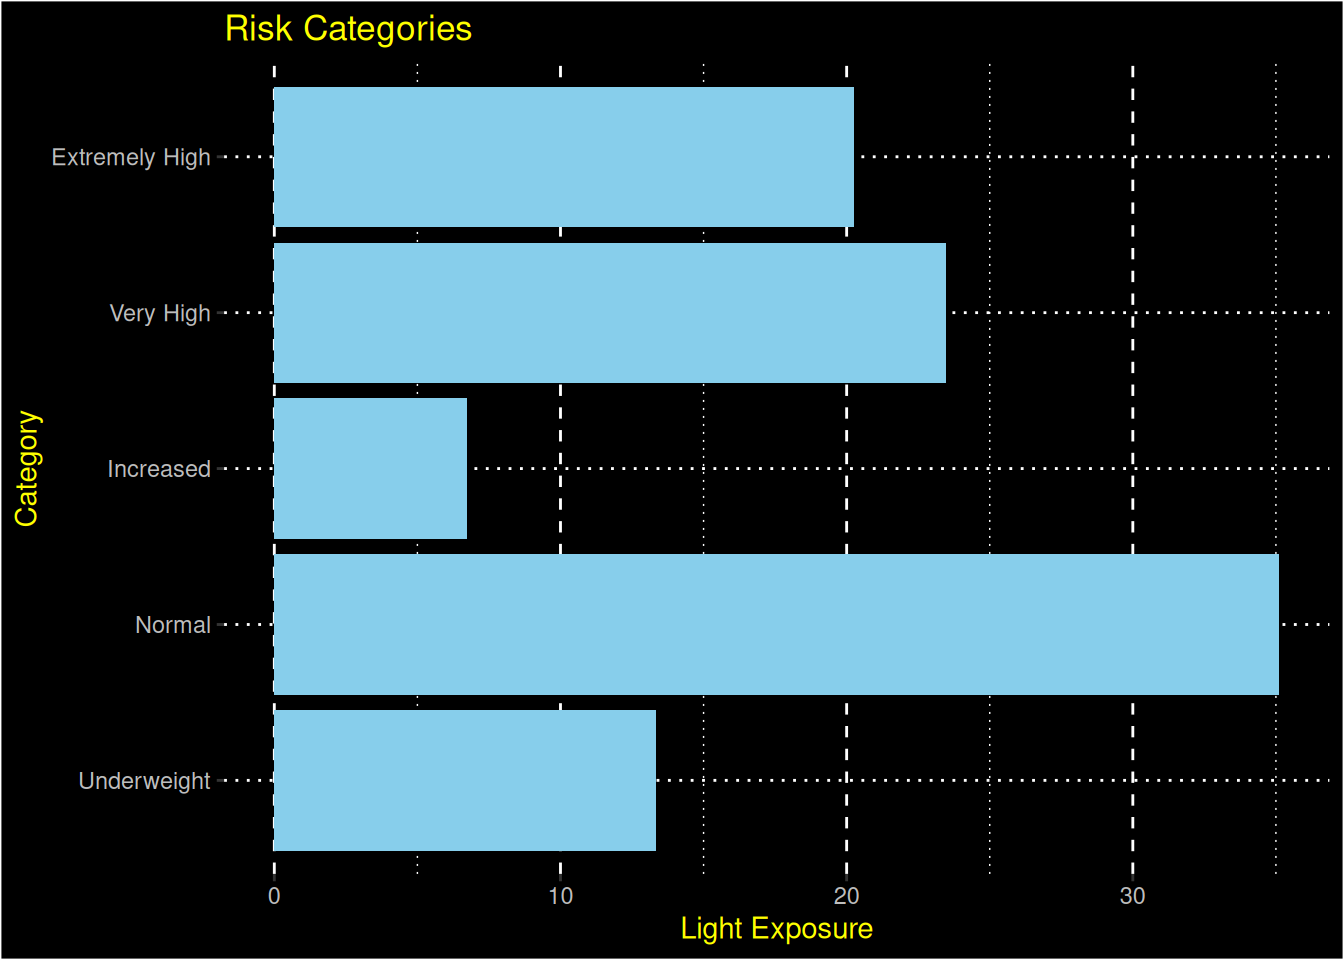

In [ ]:
library(reticulate)
library(ggplot2)

ggplot(data = py$riskdf, 
       aes(x = risk_category, y = qLight)) +
  geom_col(fill = 'skyblue') +
  labs(title='Risk Categories', 
       x='Category', y='Light Exposure')  +
  coord_flip() +
  ggplot2::theme(
    plot.background = element_rect(fill = "black"),
    panel.grid = element_line(linetype = 'dotted'),
    panel.grid.major.x = element_line(linetype = 'dashed'),
    panel.background = element_rect(fill = 'black'),
    text = element_text(color = 'yellow'),
    axis.text = element_text(color = 'gray'))

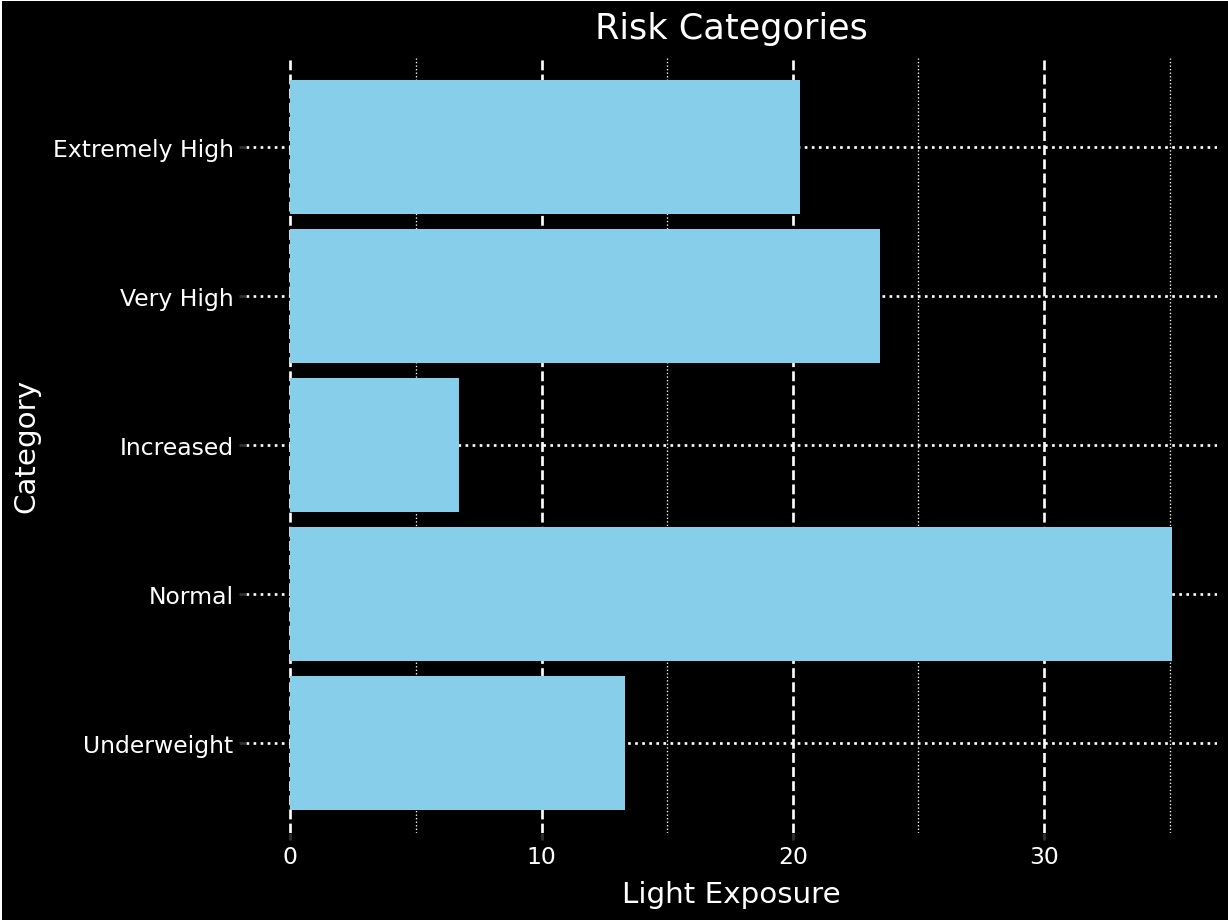

In [ ]:
from sql.ggplot import *
from plotnine import *
# for some reason, the imports above have to be in that order
# this is the jupysql way of plotting, in part

(
   ggplot(
    data = riskdf,
    mapping = aes(x = 'risk_category', y = 'qLight')) 
 + geom_col(stat = "identity", fill = "skyblue") 
 + labs(title='Risk Categories', x='Category', y='Light Exposure') 
 + coord_flip() 
 + theme(
    plot_background=element_rect(fill = "black"),
    panel_grid=element_line(linetype='dotted'),
    panel_grid_major_x=element_line(linetype='dashed'),
    panel_background=element_rect(fill='black'),
    text=element_text(color='white'))
    ).show()

## Close Connection

In [ ]:
conn.close()